In [4]:
import numpy as np
import cvxpy as cp
import time
from tqdm import tqdm
from matplotlib import pyplot as plt

from cvar_proj import  proj_sum_largest

import sys
sys.path.append('/Users/ericluxenberg/Desk/Gridmatic/build')
import mybindings

# use autoreload
%load_ext autoreload
%autoreload 2


In [5]:
def proj_cvxpy(z, k=2, alpha=1):
    z = np.array(z)
    n = len(z)
    
    # Check if the problem object is already in the cache
    if (n, k) in proj_cvxpy.cache:
        prob, alpha_ = proj_cvxpy.cache[(n, k)]
    else:
        x = cp.Variable(n)
        alpha_ = cp.Parameter(nonneg=True) 
        objective = cp.Minimize(cp.sum_squares(x - z))
        constraints = [cp.sum_largest(x, k) <= alpha_]
        prob = cp.Problem(objective, constraints)
        
        # Add the problem object to the cache
        proj_cvxpy.cache[(n, k)] = prob, alpha_
    
    alpha_.value = alpha

    s = time.time()
    _ = prob.solve(solver=cp.MOSEK)
    e = time.time()
    
    solve_time = prob._solve_time
    return solve_time

# Initialize the cache dictionary
proj_cvxpy.cache = {}

def proj_cvxpy_alt(z, k=2, alpha=1):
    z = np.array(z)
    n = len(z)
    x = cp.Variable(n)

    # identify the index of the k-th largest element
    s = time.time()
    sorted_inds = np.argsort(z)
    i = sorted_inds[-k]
    inds = sorted_inds[-k:]
    out_inds = sorted_inds[:-k]
    z = z[sorted_inds[::-1]]
    e = time.time()

    t = e - s
    
    objective = cp.Minimize(cp.sum_squares(x - z))
    constraints = [
        # cp.sum(x[inds]) <= alpha,
        # x[inds] >= x[i],
        # x[out_inds] <= x[i]
        cp.sum(x[:k]) <= alpha,
        x[:k] >= x[k-1],
        x[k:] <= x[k-1]
    ]
    prob = cp.Problem(objective, constraints)

    s = time.time()
    out = np.zeros(n)
    # unsort the solution
    out[sorted_inds] = x.value
    e = time.time()
    t += e - s

    prob.solve(solver=cp.MOSEK)
    # get the solve time from the solver
    solve_time = prob._solve_time
    return solve_time + t



In [6]:
def test(f, beta, tau_r, n):

    z = np.random.uniform(0, 1, n)
    k = int(beta*n)
    alpha = tau_r * cp.sum_largest(z, k).value

    # s = time.time()
    t = f(z,k,alpha)
    # e = time.time()
    return t

In [7]:
f = proj_sum_largest

beta = .05
tau_r = .9
n = 1000
trials = 50

def time_f(f):
    times = np.zeros(trials)
    for i in tqdm(range(trials)):
        s = time.time()
        t = test(f, beta, tau_r,n)
        e = time.time()

        if not isinstance(t, float):
            t = e-s

        times[i] = t
    return times

times_proj = time_f(proj_sum_largest)

F = lambda z, k, alpha: mybindings.sum_largest_proj(z, k, alpha, k, 0, len(z), False)
times_cpp = time_f(F)

_ = test(proj_cvxpy, beta, tau_r,n) # compile problem
times_cvxpy = time_f(proj_cvxpy)

times_alt = time_f(proj_cvxpy_alt)

100%|██████████| 50/50 [00:00<00:00, 69.57it/s]


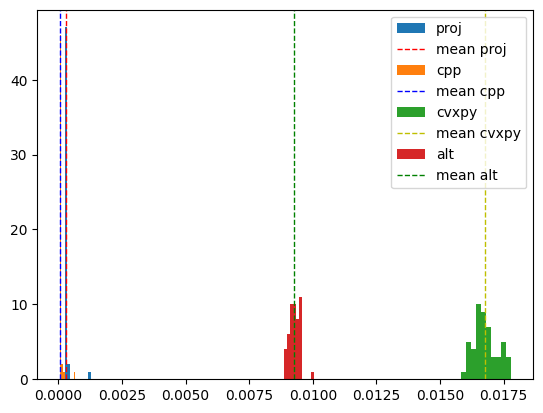

In [8]:
plt.hist(times_proj, label="proj");
plt.axvline(times_proj.mean(), color='r', linestyle='dashed', linewidth=1, label = "mean proj")
plt.hist(times_cpp, label="cpp");
plt.axvline(times_cpp.mean(), color='b', linestyle='dashed', linewidth=1, label = "mean cpp")
plt.hist(times_cvxpy, label="cvxpy");
plt.axvline(times_cvxpy.mean(), color='y', linestyle='dashed', linewidth=1, label = "mean cvxpy")
plt.hist(times_alt, label="alt");
plt.axvline(times_alt.mean(), color='g', linestyle='dashed', linewidth=1, label = "mean alt")
plt.legend()

10000


100%|██████████| 50/50 [00:06<00:00,  8.20it/s]


CVXPY succeeded 100.0 percent of the time for n=10000
30000


100%|██████████| 50/50 [00:17<00:00,  2.85it/s]


CVXPY succeeded 100.0 percent of the time for n=30000
100000


100%|██████████| 50/50 [00:57<00:00,  1.16s/it]


CVXPY succeeded 100.0 percent of the time for n=100000
300000


100%|██████████| 50/50 [02:57<00:00,  3.55s/it]


CVXPY succeeded 100.0 percent of the time for n=300000
1000000


100%|██████████| 50/50 [14:24<00:00, 17.28s/it]

CVXPY succeeded 100.0 percent of the time for n=1000000


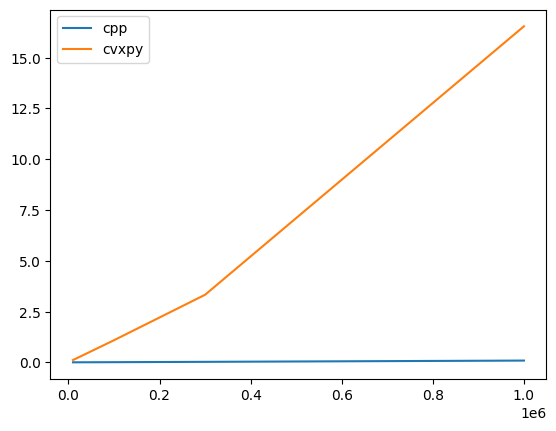

In [9]:
# mu_proj =[]
mu_cpp = []
mu_cvxpy = []
mu_alt = []

# ns = [100, 1000, 10_000, 100_000, 1_000_000] #, 1_000_000]
ns = [10**4, 3*10**4, 10**5, 3*10**5, 10**6]
# ns = [3_000_000]
cvxpy_successes = []

for n in ns:
    print(n)
    beta = .05
    tau_r = .9
    trials = 50

    def time_f(f):
        times = []
        for i in tqdm(range(trials)):
            try:
                s = time.time()
                t = test(f, beta, tau_r,n)
                e = time.time()

                if not isinstance(t, float):
                    t = e-s

                times.append(t)
            except:
                Exception

        return np.array(times)
    
    # times_proj = time_f(proj_sum_largest)
    times_cpp = time_f(F)
    times_cvxpy = time_f(proj_cvxpy)
    # times_alt = time_f(proj_cvxpy_alt)

    # mu_proj.append(times_proj.mean())
    mu_cpp.append(times_cpp.mean())
    mu_cvxpy.append(times_cvxpy.mean())
    # mu_alt.append(times_alt.mean())
    print(f"CVXPY succeeded {len(times_cvxpy)/trials*100} percent of the time for n={n}")
    cvxpy_successes.append(len(times_cvxpy)/trials)

# plt.plot(ns, mu_proj, label="proj")
plt.plot(ns, mu_cpp, label="cpp")
plt.plot(ns, mu_cvxpy, label="cvxpy")
# plt.plot(ns, mu_alt, label="alt")

plt.legend()



In [22]:
mu_cpp_extra = []

ns_extra = [3_000_000,10_000_000]

for n in ns_extra:
    print(n)
    beta = .05
    tau_r = .9
    trials = 50

    def time_f(f):
        times = []
        for i in tqdm(range(trials)):
            s = time.time()
            t = test(f, beta, tau_r,n)
            e = time.time()

            if not isinstance(t, float):
                t = e-s

            times.append(t)
    
        return np.array(times)
    
    times_cpp = time_f(F)

    mu_cpp_extra.append(times_cpp.mean())


3000000


100%|██████████| 50/50 [00:14<00:00,  3.43it/s]


10000000


100%|██████████| 50/50 [00:56<00:00,  1.12s/it]


In [23]:
ns_final = ns + ns_extra
mu_ours = mu_cpp + mu_cpp_extra

# save the results in a pickle file
import pickle
with open("cvar_proj_results.pkl", 'wb') as f:
    data = {
        "ns_final": ns_final, 
        "mu_cpp": mu_ours,
        "ns" : ns, 
        "mu_cvxpy": mu_cvxpy,
        "cvxpy_successes": cvxpy_successes}
    pickle.dump(data, f)

In [24]:
# load the results
with open('cvar_proj_results.pkl', 'rb') as f:
    data = pickle.load(f)

ns_final = data['ns_final']
mu_ours = data['mu_cpp']
ns = data['ns']
mu_cvxpy = data['mu_cvxpy']
cvxpy_successes = data['cvxpy_successes']


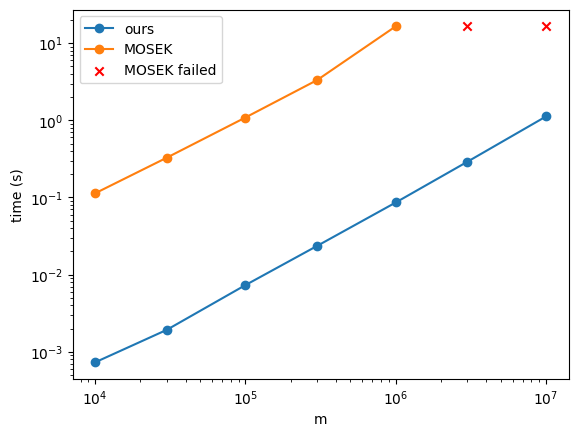

In [57]:

plt.plot(ns_final, mu_ours, label="ours", marker='o')
plt.plot(ns, mu_cvxpy, label="MOSEK", marker='o')
plt.scatter(ns_final[-2:],[mu_cvxpy[-1],mu_cvxpy[-1]], color='red', marker="x", label= "MOSEK failed")
# plt.plot(ns, mu_alt, label="Roth")

plt.legend()

# make the y,x axis log scale
plt.yscale('log')
plt.xscale('log')

plt.xlabel("m")
plt.ylabel("time (s)")
plt.savefig("../cvar-opt/proj_time.pdf")